# Programming Custom Transformers, Pipelines, and Ensemble Models to Predict Venue Ratings from the Yelp Academic Dataset

<span id='back-up'>The Yelp academic dataset </span> (included in this repository) consists of about 38,000 business listings and their relevant information. Each listing includes 15 properties, e.g. `business_id`, `full_address`, `hours`, `categories`, etc ([Click here to see all of a listing's properties](#listing)).

The **goal of this project** is to demonstrate the use of custom transformer classes, chaining custom tranformers/estimators into pipelines for composite estimators, and using feature unions to develop an ensemble model for venues' ratings prediction.

Although I will optimize my models using cross-validation, the goal of the project is *not to develop the best* model to predict star ratings based on the features in the dataset. This dataset doesn't include actual user reviews. A much more accurate predictive model would likely require natural language processing (NLP) of the costumer review data. With that caveat, let's dive into the data.

-------------

### Libraries Used

I will be using the most common python libaries for machine learning and data analysis, namely the numpy, pandas and scikit-learn libraries. I'll be using sci-kit learn's linear and non-linear regressors for modeling the data. As most of the data is not in the correct format (sci-kit learn requires numpy arrays or pandas dataframes as inputs) I'll write custom transformers to modify the original data structure for it.

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import dill
import pandas as pd
import numpy as np
import random as rd
from sklearn import base
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Importing and Exploring the Data

In [3]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

<span id='listing'> I always find it nice to see how the data is structured. `data` is a a list of businesses (~38,000). I have just printed the first listed buisness to see all of it's associated metadata ([back to the introduction](#back-up)). </span>

In [8]:
for i in data[0]:
    print (i,':', data[0][i])

business_id : vcNAWiLM4dR7D2nwwJ7nCA
full_address : 4840 E Indian School Rd
Ste 101
Phoenix, AZ 85018
hours : {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}
open : True
categories : ['Doctors', 'Health & Medical']
city : Phoenix
review_count : 7
name : Eric Goldberg, MD
neighborhoods : []
longitude : -111.983758
state : AZ
stars : 3.5
latitude : 33.499313
attributes : {'By Appointment Only': True}
type : business


Keeping the labels separate from the features and splitting the dataset into a training and test dataset.

In [9]:
star_ratings = [business['stars'] for business in data]

In [22]:
np.array(star_ratings).mean()

3.6729137013021247

In [11]:
# from sklearn.model_selection
xtrain, xtest, ytrain, ytest = train_test_split(data, star_ratings, 
                                                train_size=0.8, 
                                                random_state=100)


### Building a City-based Predictive Model

This first estimator takes all the cities in the dataset, calculates the average, and then predicts that average for any venue in a city.

As a a model, it is quite crude, but in some cases where customers in some cities may rate higher than other cities, it would make for a baseline predictor, especially when combined with category data.

I added a default rating of 3.67 (dataset mean) if the city doesn't exist in the dataset.

In [23]:
class CityEstimator(base.BaseEstimator, base.RegressorMixin):

    def fit(self, X, y):
        
        # X is input list of rows. y is corresponding star ratings
        city = [business['city'] for business in X]
        
        # using dataframes for grouped means
        city_stars = pd.DataFrame({'city': city,
                                   'star_ratings': y})
        city_avg = city_stars.groupby(['city'], as_index=False).mean()
        
        # going back to the dictionary as easier to add missing data during predict
        agg_city = city_avg['city'].to_list()
        agg_stars = city_avg['star_ratings'].to_list()

        self.city_agg = {i:j for i,j in zip(agg_city, agg_stars)}
   
        return self

    def predict(self, X):
        
        predX = [business['city'] for business in X]
        predY = []
        for i in predX:
            if i in self.city_agg:
                predY.append(self.city_agg[i])
            else:
                predY.append(3.67) # if city is not in dataset, if just guesses 2.5
        return predY


I'll be using the mean squared error and the mean absolute error as my scoring metric. The former is the sum of the squared difference, whereas the latter is the sum of the absolute difference between actual `y` and predicted `y` 

In [25]:
def pred_score(model, xdata, ydata):
    pred = model.predict(xdata)
    score = []
    score.append(mean_squared_error(ydata, pred))
    score.append(mean_absolute_error(ydata,pred))
    return pred, score

In [18]:
# Initializing Model
city_est = CityEstimator()
city_est.fit(xtrain, ytrain)

CityEstimator()

In [26]:
# Testing with original data
city_test_pred, city_score = pred_score(city_est, xtest, ytest)
print(city_score)

[0.8121962490416534, 0.7198220103416592]


At first glance the MSE of 0.81 and MAE of 0.72 looks low. But if we plot our data, we'll see that our data is centered at 3.67. a MAE of 0.72 suggests the average prediction could range from 2.95 to  4.39, a fairly bigger when it comes to user ratings.

Let's plot some subset of the data to visualize our predictions.

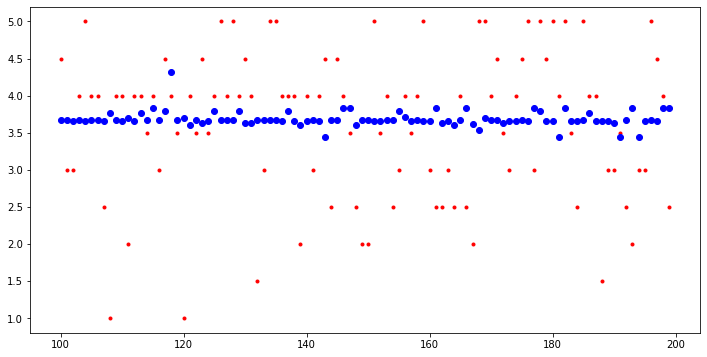

In [28]:
city_venue = list(range(0,len(xtest)))
plt.figure(figsize=(12,6))
w = 100 # shift window to plot
plt.plot(city_venue[w+0:w+100], ytest[w+0:w+100], 'r.' ,label='Actual')
plt.plot(city_venue[w+0:w+100], city_test_pred[w+0:w+100], 'bo' ,label='Pred')

We can see that the model does a really poor job of predicting most venues.

(array([ 102.,  146.,  284.,  620., 1050., 1697., 1667., 2022.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 8 Patch objects>)

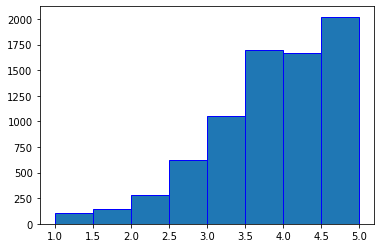

In [35]:
plt.hist(ytest, bins=8, range=(1,5), edgecolor='b')

### Column Select Transformer 

If I want to use particular features as input for a model, I have to make sure it is shaped as a numpy array for sci-kit learn's regressors. The format of a numpy array is `[[$a_{1}$,$b_{1}$], [$a_{2}$,$b_{2}$], ...]

In [36]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self

    def transform(self, X):
        tx_undata = [] #not formatted so UNformatted DATA
        for i in self.col_names:
            tx_undata.append([row[i] for row in X])

        len_col = len(tx_undata)

        tx_data = []
        for i in tx_undata[0]:
            tx_data.append([i])
        for i in range(1, len(self.col_names)):
            for j in range(len(tx_data)):
                tx_data[j].append(tx_undata[i][j])

        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        return tx_data


Testing that our column transformer takes in a list of columns, and then outputs that in a numpy array-like list.

In [38]:
col_in = ['latitude', 'longitude']
cst = ColumnSelectTransformer(col_in)
data_subset = data[0:5]
cst2 = cst.fit_transform(data_subset)
cst3 = [[i['latitude'], i['longitude']] for i in data_subset]
print(cst2)
print(cst2 == cst3)

[[33.499313, -111.983758], [43.238893, -89.335844], [43.252267, -89.353437], [43.251045, -89.374983], [43.2408748, -89.3437217]]
True


I'll use `pipeline` from the sklearn.pipeline library to sequentially apply my column transformer, and then pass that data to a regressor. In this case I will be using a k-nearest neighbors regressor, which averages the value of the k nearest neighbors (Euclidean distance) to predict the value for input (lat, long).

In [39]:
col_in = ['latitude', 'longitude']

pipe = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                 ('knear', KNeighborsRegressor(n_jobs=-1))])


I'm using the exhaustive `GridSearchCV` function from the scikit library to optimize the `n_neighbors` and `weights` of each neighbor in the knn algorithm. Note that to pipe the parameter grid, I have to append the estimator name (that I can name arbitrarily) as `name__`. In this particular case, it is `knear__`. 

In [40]:
kparams = { 'knear__n_neighbors': [90, 100, 110, 120, 200],
            'knear__weights': ['uniform', 'distance']}

cn = GridSearchCV(pipe, kparams, cv=5, scoring='neg_mean_squared_error')
cn.fit(xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntx',
                                        ColumnSelectTransformer(col_names=['latitude',
                                                                           'longitude'])),
                                       ('knear',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=-1,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
             iid='warn', n_jobs

In [41]:
cn.best_params_

{'knear__n_neighbors': 100, 'knear__weights': 'uniform'}

In [42]:
pipe = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                 ('knear', KNeighborsRegressor(n_neighbors=100, n_jobs=-1))])
pipe.fit(xtrain, ytrain)

Pipeline(memory=None,
         steps=[('columntx',
                 ColumnSelectTransformer(col_names=['latitude', 'longitude'])),
                ('knear',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=-1, n_neighbors=100, p=2,
                                     weights='uniform'))],
         verbose=False)

In [43]:
print(pred_score(pipe,xtest, ytest)[1])

[0.7994039536109647, 0.7094517659462309]


The latitude and longitude model barely improves our predictions.

## Category Model


In [49]:
# Examples

print(data[rd.randrange(0,len(data))]['categories'])
print(data[rd.randrange(0,len(data))]['categories'])
print(data[rd.randrange(0,len(data))]['categories'])

['Tree Services', 'Home Services', 'Contractors']
['Active Life', 'Golf']
['Fast Food', 'Japanese', 'Restaurants']


In [51]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ct_dt = []
        # the extra loop is because this is a list nested in a list nested in a list
        for i in X:
            for j in i:
                ct_dt.append({})
                for k in j:
                    ct_dt[-1][k] = 1

        return ct_dt

In [53]:
col_in = ['categories']
cst = ColumnSelectTransformer(col_in).fit_transform(data_subset)
for i in cst:
    print(i)
print('\n')

cst2 = DictEncoder().fit_transform(cst)
for i in cst2:
    print(i)

cst3 = DictVectorizer().fit_transform(cst2)
for i in cst3:
    print(i)


[['Doctors', 'Health & Medical']]
[['Restaurants']]
[['American (Traditional)', 'Restaurants']]
[['Food', 'Ice Cream & Frozen Yogurt', 'Fast Food', 'Restaurants']]
[['Chinese', 'Restaurants']]


{'Doctors': 1, 'Health & Medical': 1}
{'Restaurants': 1}
{'American (Traditional)': 1, 'Restaurants': 1}
{'Food': 1, 'Ice Cream & Frozen Yogurt': 1, 'Fast Food': 1, 'Restaurants': 1}
{'Chinese': 1, 'Restaurants': 1}
  (0, 2)	1.0
  (0, 5)	1.0
  (0, 7)	1.0
  (0, 0)	1.0
  (0, 7)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 1)	1.0
  (0, 7)	1.0


In [ ]:
col_in = ['categories']
pipe2 = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                  ('dict_enc', DictEncoder()),
                  ('dict_vec', DictVectorizer()),
                  ('ridge', Ridge())])

kparams = { 'ridge__alpha': [3.0, 3.5, 4.0, 5.0, 6.0, 7.0, 10.0]}

catn = GridSearchCV(pipe2, kparams, cv=5, scoring='neg_mean_squared_error')
catn.fit(xtrain, ytrain)
catn.best_params_

In [ ]:
col_in = ['categories']
pipe2 = Pipeline([('column tx', ColumnSelectTransformer(col_in)),
                  ('dict fixer', DictEncoder()),
                  ('dict vector', DictVectorizer()),
                  ('ridge model', Ridge(alpha=7.0))])

pipe2.fit(xtrain, ytrain)

In [ ]:
print(pred_score(pipe2, xtest, ytest)[1])

## Attribute Model



In [ ]:
class DictAttEncoder(base.BaseEstimator, base.TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #self.at_lt = X   # attribute list
        at_dt = []  # attribute flat dictionary
        for i in X:
            for j in i:
                at_dt.append({})
                for k, l in j.items():
                    if not type(l) is dict:
                        if l == False:
                            at_dt[-1][k] = 0
                        elif l == True:
                            at_dt[-1][k] = 1
                        else:
                            at_dt[-1]['{}_{}'.format(k, l)] = 1
                    if type(l) is dict:
                        for m, n in l.items():
                            if n == False:
                                at_dt[-1]['{}_{}'.format(k, m)] = 0
                            elif n == True:
                                at_dt[-1]['{}_{}'.format(k, m)] = 1

        return at_dt

In [ ]:
col_in = ['attributes']
cst = ColumnSelectTransformer(col_in).fit_transform(data_subset)
for i in cst:
    print(i)
print('\n')

cst2 = DictAttEncoder().fit_transform(cst)
for i in cst2:
    print(i)


In [ ]:
col_in = ['attributes']
pipe3 = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                  ('dict_fix', DictAttEncoder()),
                  ('dict_vec', DictVectorizer()),
                 ('forest', RandomForestRegressor(n_jobs=-1))])

kparams = { 'forest__n_estimators': [200, 300, 400],
            'forest__max_depth': [10, 25, 40],
            'forest__min_samples_split': [2, 10, 25, 50]}

fn = GridSearchCV(pipe3, kparams, cv=5, scoring='neg_mean_squared_error')
fn.fit(xtrain, ytrain)
fn.best_params_



In [ ]:
col_in = ['attributes']
pipe3 = Pipeline([('column tx', ColumnSelectTransformer(col_in)),
                  ('dict fixer', DictAttEncoder()),
                  ('dict vector', DictVectorizer()),
                 ('forest model', RandomForestRegressor(n_jobs=-1, max_depth=40,
                                                        n_estimators=300,
                                                        min_samples_split=50))])

pipe3.fit(xtrain, ytrain)

print(pred_score(pipe3, xtest, ytest)[1])

## Residual Estimator

In [ ]:
class DataAndResidualRegressor(base.BaseEstimator, base.TransformerMixin):

    def fit(self, X, y):
        self.data = X
        self.y_act = y

        self.data_model1 = RandomForestRegressor(n_jobs=-1, max_depth=40,
                                                        n_estimators=300,
                                                        min_samples_split=50)
        #self.data_model2 = Ridge(alpha=3.0)
        self.data_model2 = RandomForestRegressor(n_jobs=-1, max_depth=40,
                                                        n_estimators=300,
                                                        min_samples_split=50)

        self.data_model1.fit(self.data, self.y_act)
        self.y_est = self.data_model1.predict(self.data)
        self.y_res = self.y_act - self.y_est

        self.data_model2.fit(self.data, self.y_res)

        return self

    def predict(self, X):
        y_predict = self.data_model1.predict(X) + self.data_model2.predict(X)

        return y_predict


In [ ]:
col_in = ['attributes']
pipe4 = Pipeline([('column tx', ColumnSelectTransformer(col_in)),
                  ('dict fixer', DictAttEncoder()),
                  ('dict vector', DictVectorizer()),
                  ('data res model', DataAndResidualRegressor())])

pipe4.fit(xtrain, ytrain)
print(pred_score(pipe4, xtest, ytest)[1])

## Custom Estimator Transformer

In [ ]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, estimator):
        self.estimator = estimator
        #return self

    # What needs to be done here?

    def fit(self, X, y):
        self.estimator.fit(X,y)
        return self

    # Fit the stored estimator.
    # Question: what should be returned?

    def transform(self, X):
        self.y_est = self.estimator.predict(X)
        self.y_out = [[i] for i in self.y_est]

        return self.y_out

In [ ]:

# Use predict on the stored estimator as a "transformation".
# Be sure to return a 2-D array.

############################################################

data = dill.load(open('data.pkd', 'rb'))
star_ratings = [row['stars'] for row in data]

city_est = CityEstimator()
city_trans = EstimatorTransformer(city_est)

city_trans.fit(data, star_ratings)
assert ([r[0] for r in city_trans.transform(data[:5])]
        == city_est.predict(data[:5]))



union = FeatureUnion([('city est', city_trans),
                      ('lat long', latlong_trans),
                      ('cat mod', cat_trans),
                      ('att mod', att_trans)])



In [ ]:
from sklearn.pipeline import FeatureUnion


city_trans = EstimatorTransformer(city_est)
latlong_trans = EstimatorTransformer(pipe)
cat_trans = EstimatorTransformer(pipe2)
att_trans = EstimatorTransformer(pipe4)


union = FeatureUnion([('city est', city_trans),
                      ('lat long', latlong_trans),
                      ('cat mod', cat_trans),
                      ('att mod', att_trans)])

In [ ]:


lr_model = LinearRegression()
#lr_model = RandomForestRegressor(n_estimators=20)

pipe5 = Pipeline([('columns all', union),
                 ('lin model', lr_model)])

pipe5.fit(xtrain, ytrain)

In [ ]:
pipe5_y, p5_score = pred_score(pipe5, xtest, ytest)
print(p5_score)

In [ ]:
city_venue = list(range(0,len(xtest)))
plt.figure(figsize=(12,6))
plt.plot(city_venue[0:100], ytest[0:100], 'r.' ,label='Actual')
plt.plot(city_venue[0:100], pipe5_y[0:100], 'bo' ,label='Pred')

In [ ]:
city_venue = list(range(0,len(xtest)))
plt.figure(figsize=(12,6))
plt.plot(city_venue[0:100], ytest[0:100], 'r.' ,label='Actual')
plt.plot(city_venue[0:100], city_test_pred[0:100], 'bo' ,label='Pred')